In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module
import module.samplers
import module.hamiltonians
import module.wavefunctions
import module.misc.atomic_orbitals

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
key = jax.random.PRNGKey(0)

In [3]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

(-4.0, 2.0)

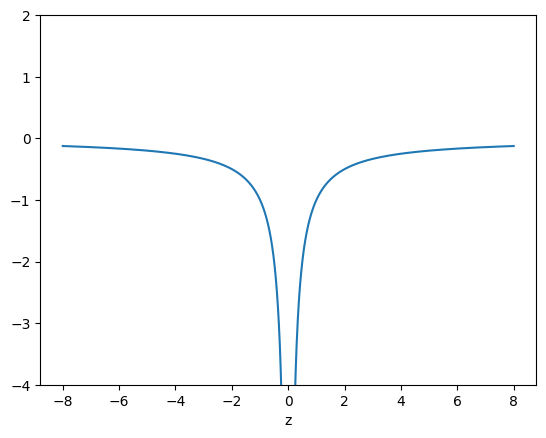

In [4]:
# electric field

#
# The potential energy function depending on the coordinates
#
def potential(x, params):
    d = jnp.sqrt(jnp.sum(x**2, axis = 1))
    return -1/d


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)

r, line = getLine(0,0, r_max=8)
plt.plot(r, potential(line, None))
plt.xlabel("z")
plt.ylim(-4, 2)

In [5]:
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(15, name="dense1", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        x = nn.Dense(15, name="dense2", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        x = nn.Dense(15, name="dense3", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        x = nn.Dense(1, name="dense4", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        return -jnp.squeeze(x)

In [6]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (3,))
        self.nn = NN()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((3,)))
        return nn_param
    
    def calc_logpsi(self, param, x):
        return self.nn.apply(param, x)

In [7]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

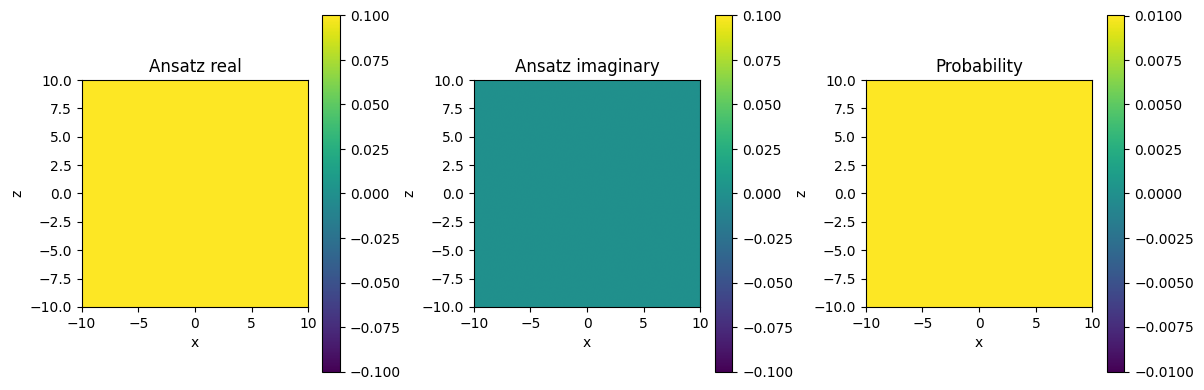

In [8]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

l = 10
ep = 0.1

xs = jnp.linspace(-l, l, num = 1000)
zs = jnp.linspace(-l, l, num = 1000)
xss, zss = jnp.meshgrid(xs, zs)
im = jnp.stack((xss, xss*0, zss), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
res = jnp.flip(res, axis = 0)

a = axs[0].imshow(res.real, extent = [-l, l, -l,l], vmin = -ep, vmax = ep)
axs[0].set_title("Ansatz real")
axs[0].set_xlabel("x")
axs[0].set_ylabel("z")
plt.colorbar(a, ax=axs[0])

a = axs[1].imshow(res.imag, extent = [-l, l, -l, l], vmin = -ep, vmax = ep)
axs[1].set_title("Ansatz imaginary")
axs[1].set_xlabel("x")
axs[1].set_ylabel("z")
plt.colorbar(a, ax=axs[1])

a = axs[2].imshow(jnp.abs(res)**2, extent = [-l, l, -l, l], vmin = -ep**2, vmax = ep**2)
axs[2].set_title("Probability")
axs[2].set_xlabel("x")
axs[2].set_ylabel("z")
plt.colorbar(a, ax=axs[2])



f.tight_layout()

In [9]:
sampler = module.samplers.MCMCsimple(ansatz, 1)

In [10]:
subsampling = 10

In [11]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

In [12]:
samples, r = get_samples(10000)
print(r)

0.71655


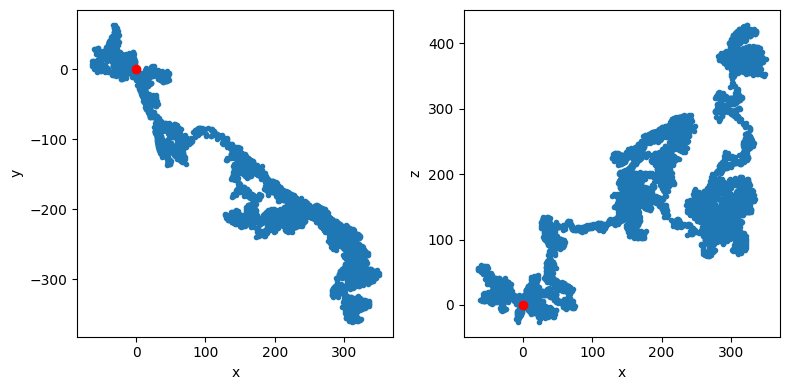

In [13]:
f, axs = plt.subplots(1,2,figsize = (8,4))
axs[0].scatter(samples[:,0], samples[:,1], marker = ".")
axs[0].scatter([0],[0], color = "r")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].scatter(samples[:,0], samples[:,2], marker = ".")
axs[1].set_xlabel("x")
axs[1].set_ylabel("z")
axs[1].scatter([0],[0], color = "r")

f.tight_layout()

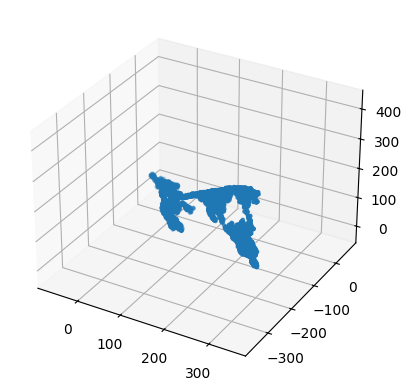

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(samples[:,0],samples[:,1], samples[:,2], marker = ".")

## 2. Energy Minimisation

In [15]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc.real)
    dE = jnp.std(E_loc.real)

    logpsi_red = lambda parameters: jnp.conjugate(orbital.calc_logpsi(parameters, samples))
    y, v = netket.jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

In [16]:
def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1/N*x, b)

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)

    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = jax.vjp(f, parameters)[1](e)[0]
    return  jax.tree_util.tree_map(lambda v: 1/N**2 * a * v, b)

@partial(jax.jit, static_argnames=['orbital'])
def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a-b, s1, s2)

In [17]:
eps = 1e-4

def reg_S(ansatz, param, samples, v):
    u = eval_S(ansatz, param, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a + eps * b, u, v)

@jax.jit
def calc_natural_grad(param, samples):
    A = lambda v: reg_S(ansatz, param, samples, v)
    b, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)
    return jax.scipy.sparse.linalg.cg(A, b)[0], E, dE

In [18]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": []}
param = ansatz.init_param(key)

In [19]:
N = 4000
epoch = 2000

# define
optimizer = optax.sgd(learning_rate=0.03)

# initialise
optimizer_state = optimizer.init(param)

for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 2000/2000 [02:22<00:00, 13.99it/s]


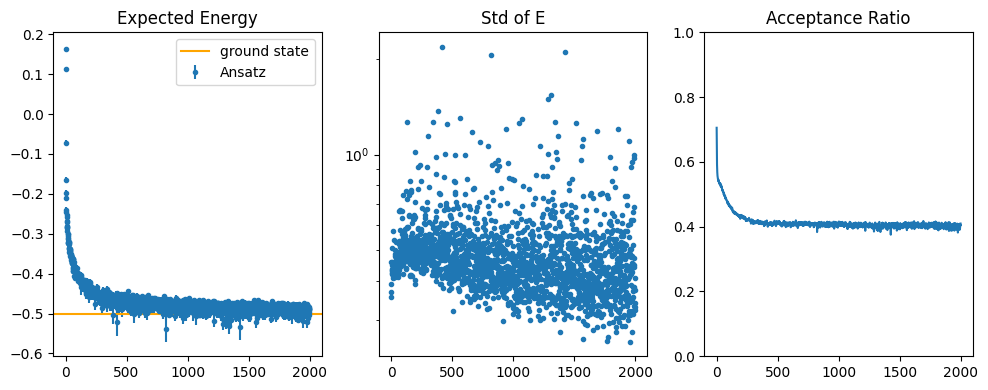

In [20]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1,3, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")
ax[0].axhline(-0.5, label = "ground state", color = "orange")
ax[0].legend(loc = "upper right")
# ax[0].set_ylim(-0.63, -0.53)

# ax[1].scatter(i, jnp.abs(numpy_stats["E"]+0.616515) , label = "error", marker = ".")
# ax[1].set_title("Energy Error")
# ax[1].set_yscale("log")

ax[1].scatter(i, stats["dE"], marker = ".")
ax[1].set_title("Std of E")
ax[1].set_yscale("log")

ax[2].plot(stats["ratio"])
ax[2].set_ylim(0,1)
ax[2].set_title("Acceptance Ratio")

f.tight_layout()

n_param = sum(x.size for x in jax.tree_util.tree_leaves(param))

In [21]:
## energy density

l = 0.1
xs = jnp.linspace(-l, l, num = 100)
ys = jnp.linspace(-l, l, num = 100)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0 + 1e-4), axis = 2)

xs = jnp.linspace(-l, l, num = 1000)
zs = jnp.linspace(-l, l, num = 1000)
xss, zss = jnp.meshgrid(xs, zs)
im = jnp.stack((xss, xss*0, zss), axis = 2)


res = hamiltonian.calc_H_loc(ansatz, param, im.reshape(-1, 3)).reshape(xss.shape)
res = jnp.flip(res, axis = 0)

Text(0.5, 1.0, 'local energy')

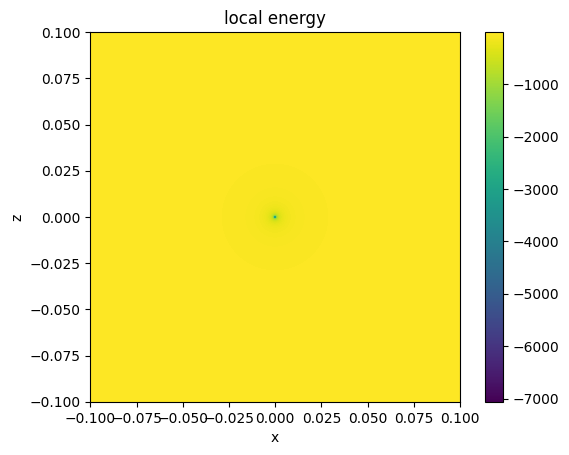

In [22]:
plt.imshow(res.real, extent = [-l,l,-l,l])
# plt.imshow(res.imag)
plt.ylabel("z")
plt.xlabel("x")
plt.colorbar()
plt.title("local energy")

In [23]:
r, line = getLine(0,0,r_max=5)
psi = ansatz.calc_psi(param, line + 1e-4)
hloc = hamiltonian.calc_H_loc(ansatz, param, line + 1e-4)

Text(0.5, 1.0, 'logarithmic plot of $\\Psi(r)$')

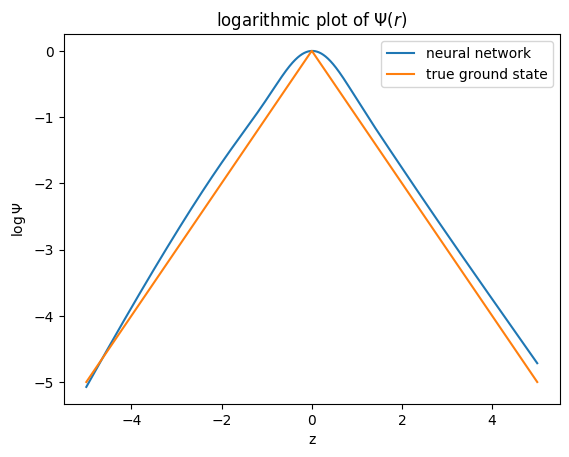

In [24]:
plt.plot(r, jnp.log(psi.real)-jnp.max(jnp.log(psi.real)), label = "neural network")
plt.plot(r, -jnp.abs(r)-jnp.max(-jnp.abs(r)), label = "true ground state")
plt.xlabel("z")
plt.legend()
plt.ylabel("$\\log \Psi$")
plt.title("logarithmic plot of $\Psi(r)$")

Text(0, 0.5, 'energy')

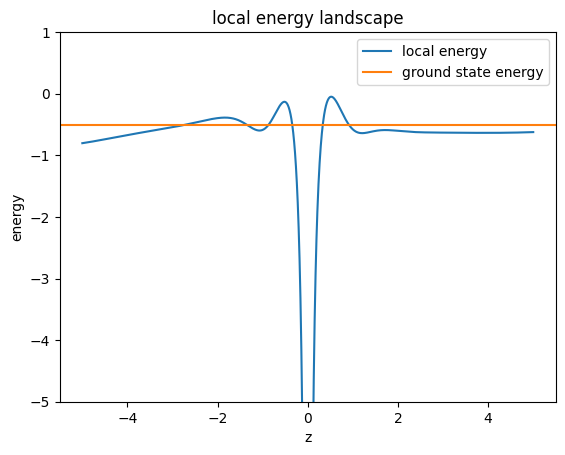

In [25]:
plt.plot(r, hloc.real, label = "local energy")
plt.axhline(-0.5, label = "ground state energy", color = "C1")
plt.ylim(-5,1)
plt.legend()
plt.title("local energy landscape")
plt.xlabel("z")
plt.ylabel("energy")

In [26]:
N = 10000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples).real
E_f = jnp.mean(H_loc)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
# print("Energy Error:", (jnp.mean(H_loc) + 0.616515)/0.616515)
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.40374000000000004
Expected Energy: -0.48805379888010775 +/- 0.0035722541327430557
Std of Expected Energy: 0.35722541327430557
